In [1]:
import pandas as pd
import numpy as np
import cv2
import random
import keras
from keras.preprocessing.image import img_to_array, load_img
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
import os

Using TensorFlow backend.


In [2]:
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
np.random.seed(0)

In [3]:
def load_image(image_file):
    return mpimg.imread(str(image_file.strip()))

In [4]:
def preprocess(image):
    image = image[60:-25, :, :]
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    return image

In [5]:
def choose_image(center, left, right, steering_angle):
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(left), steering_angle + 0.2
    elif choice == 1:
        return load_image(right), steering_angle - 0.2
    return load_image(center), steering_angle

In [6]:
def random_flip(image, steering_angle):
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

In [7]:
def random_translate(image, steering_angle, range_x, range_y):
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

In [8]:
def random_shadow(image):
    height, width = image.shape[:2]
    x1, y1 = int(width * np.random.rand()), 0
    x2, y2 = int(width * np.random.rand()), height
    xm, ym = np.mgrid[0:height, 0:width]

    mask = np.zeros_like(image[:, :, 1])
    mask[((ym - y1) * (x2 - x1) - (y2 - y1) * (xm - x1) > 0)] = 1

    cond = mask == np.random.randint(2)
    s_ratio = np.random.uniform(low=0.2, high=0.5)

    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hls[:, :, 1][cond] = hls[:, :, 1][cond] * s_ratio
    return cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)

In [9]:
def random_brightness(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

In [10]:
def augment(center, left, right, steering_angle, range_x=100, range_y=10):
    image, steering_angle = choose_image(center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_translate(image, steering_angle, range_x, range_y)
    image = random_shadow(image)
    image = random_brightness(image)
    return image, steering_angle

In [11]:
def batch_generator(image_paths, steering_angles, batch_size, is_training):
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    print(image_paths.shape)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            if is_training and np.random.rand() < 0.6:
                image, steering_angle = augment(center, left, right, steering_angle)
            else:
                image = load_image(center)
            images[i] = preprocess(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers

In [12]:
def load_data(test_size):
    data_df = pd.read_csv('data/driving_log.csv', names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])
    X = data_df[['center', 'left', 'right']].values
    y = data_df['steering'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
    return X_train, X_test, y_train, y_test

In [13]:
def build_model(keep_prob):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
    model.add(Conv2D(24, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(36, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(48, 5, 5, activation='elu', subsample=(2, 2)))
    model.add(Conv2D(64, 3, 3, activation='elu'))
    model.add(Conv2D(64, 3, 3, activation='elu'))
    model.add(Dropout(keep_prob))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    model.summary()

    return model

In [14]:
test_size = 0.2
keep_prob = 0.5
nb_epoch = 10
samples_per_epoch = 20000
batch_size = 40
learning_rate = 1.0e-4

data = load_data(test_size) #6564, 1641
model = build_model(keep_prob)
#train_model(model, learning_rate, batch_size, samples_per_epoch, nb_epoch, *data)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 98, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 47, 36)    21636       convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 5, 22, 48)     43248       convolution2d_2[0][0]            
___________________________________________________________________________________________

In [15]:
checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=True,
                             mode='auto')

model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))

In [16]:
history = model.fit_generator(batch_generator(data[0], data[2], batch_size, True),
                    samples_per_epoch,
                    nb_epoch,
                    max_q_size=1,
                    validation_data=batch_generator(data[1], data[3], batch_size, False),
                    nb_val_samples=len(data[1]),
                    callbacks=[checkpoint],
                    verbose=1)

(6564, 3)
Epoch 1/10
20000/20000 [==============================] - 141s - loss: 0.0331 - val_loss: 0.0182
Epoch 2/10
20000/20000 [==============================] - 140s - loss: 0.0310 - val_loss: 0.0175
Epoch 3/10
20000/20000 [==============================] - 145s - loss: 0.0303 - val_loss: 0.0181
Epoch 4/10
20000/20000 [==============================] - 151s - loss: 0.0294 - val_loss: 0.0149
Epoch 5/10
20000/20000 [==============================] - 144s - loss: 0.0280 - val_loss: 0.0184
Epoch 6/10
20000/20000 [==============================] - 144s - loss: 0.0258 - val_loss: 0.0172
Epoch 7/10
20000/20000 [==============================] - 142s - loss: 0.0265 - val_loss: 0.0157
Epoch 8/10
20000/20000 [==============================] - 142s - loss: 0.0251 - val_loss: 0.0147
Epoch 9/10
20000/20000 [==============================] - 141s - loss: 0.0244 - val_loss: 0.0155
Epoch 10/10
20000/20000 [==============================] - 138s - loss: 0.0238 - val_loss: 0.0163


In [20]:
history.history

{'loss': [0.03313881028816104,
  0.030968242280185222,
  0.03030335311591625,
  0.02940445982478559,
  0.028002461338415743,
  0.025798149770125747,
  0.026458875240758063,
  0.02514591164328158,
  0.02442270285822451,
  0.02377347272541374],
 'val_loss': [0.01816998960982476,
  0.017478557126153083,
  0.018106709389636915,
  0.014927200440849577,
  0.01842146108503498,
  0.017153424432589895,
  0.015694718087269438,
  0.014718369902333333,
  0.015502366503434522,
  0.016343150077210294]}

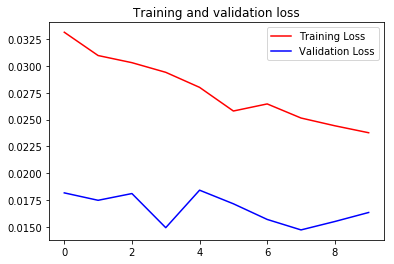

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

(1, 31, 98, 24)
(1, 14, 47, 36)
(1, 5, 22, 48)
(1, 3, 20, 64)
(1, 1, 18, 64)
(1, 1, 18, 64)


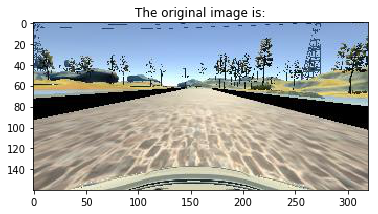

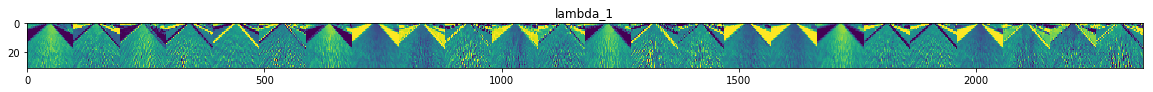

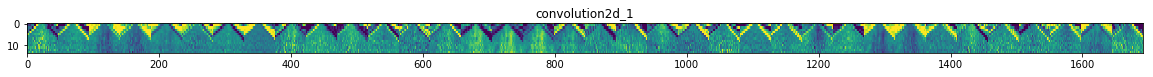

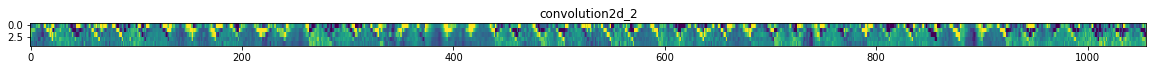

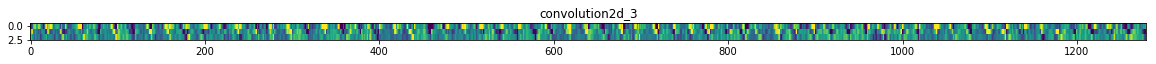

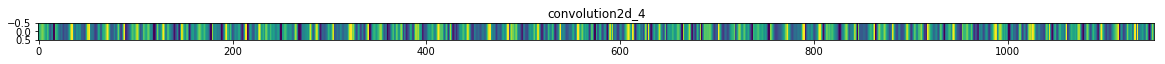

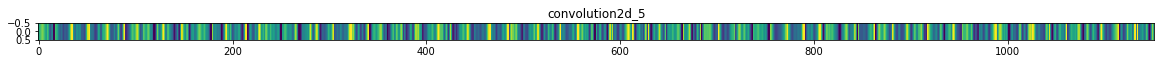

In [27]:
successive_outputs = [layer.output for layer in model.layers[1:]]

visualization_model = keras.models.Model(input = model.input, output = successive_outputs)

file_name = data[1][0][0] # select any random file
image_file = os.path.join('data/IMG', file_name)

img = load_img(image_file)

x = np.asarray(img)     

plt.imshow(x)
plt.title('The original image is:')

x = preprocess(x)
x = np.array([x])

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size1       = feature_map.shape[ 1]  # feature map shape (1, size1, size2, n_features)
        size2       = feature_map.shape[ 2]  # feature map shape (1, size1, size2, n_features)
        print(feature_map.shape)
        
        # We will tile our images in this matrix
        display_grid = np.zeros((size1, size2 * n_features))

        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size2 : (i + 1) * size2] = x # Tile each filter into a horizontal grid

        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 